# Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium.features import Choropleth
import datetime as dt
import streamlit as st
from streamlit_folium import folium_static
import plotly.express as px
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image


# Data inladen

In [2]:
states = gpd.read_file('gz_2010_us_040_00_5m.json')
crimes_us = pd.read_csv('USPoliceViolence.csv')
states_abbr = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
pop_20_21 = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/NST-EST2021-alldata.csv')
pop_us = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv')
unemploy_us = pd.read_excel('unemploy.xls')
unemploy_19_20 = pd.read_excel('unemployment.xlsx')
race = pd.read_csv('race.csv')

# Data manipulatie

### Hoofd dataset (crimes_us)

In [3]:
crimes_us = pd.merge(crimes_us, states_abbr, how = 'inner', right_on = 'Abbreviation', left_on = 'State')
crimes_us.drop('Abbreviation', axis = 1, inplace= True)
crimes_us = pd.merge(crimes_us, states, how = 'inner', right_on = 'NAME', left_on = 'State_y')

crimes_us['crimes_per_state'] = crimes_us.groupby('State_x')['State_x'].transform('count')

crimes_us['datetime'] = pd.to_datetime(crimes_us['Date of Incident (month/day/year)'], format = '%Y-%m-%d')
crimes_us['year'] = crimes_us['datetime'].dt.year

crimes_us.drop('geometry', axis=1, inplace=True)
crimes_us.drop(['Zipcode', 'Agency responsible for death', 'GEO_ID'], axis = 1, inplace = True)

crimes_us['year'] = crimes_us['year'].astype(str)

### Dataset (pop_20_21 en pop_us)

In [4]:
pop_20_21 = pop_20_21[['NAME', 'POPESTIMATE2020', 'POPESTIMATE2021']]

pop_us = pd.merge(pop_us, pop_20_21, how = 'left', on = 'NAME')

pop_us = pop_us[['NAME','POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 
                'POPESTIMATE2013', 'POPESTIMATE2014', 'POPESTIMATE2015',
                'POPESTIMATE2016', 'POPESTIMATE2017', 'POPESTIMATE2018',
                'POPESTIMATE2019', 'POPESTIMATE2020', 'POPESTIMATE2021']]

pop_us.rename(columns = {'POPESTIMATE2010' : '2010', 'POPESTIMATE2011' : '2011',
                         'POPESTIMATE2012' : '2012', 'POPESTIMATE2013' : '2013',
                         'POPESTIMATE2014' : '2014', 'POPESTIMATE2015' : '2015',
                         'POPESTIMATE2016' : '2016', 'POPESTIMATE2017' : '2017',
                         'POPESTIMATE2018' : '2018', 'POPESTIMATE2019' : '2019',
                         'POPESTIMATE2020' : '2020', 'POPESTIMATE2021' : '2021'}, inplace = True)

pop_us = pd.melt(pop_us, id_vars = 'NAME', value_vars = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'],
                value_name = 'population', var_name = 'year')

### Hoofd dataset samenvoegen met populatie data

In [5]:
crimes_us = pd.merge(crimes_us, pop_us, how = 'outer', left_on = ['NAME', 'year'], right_on = ['NAME', 'year'])
crimes_us = crimes_us[crimes_us['State_x'].notna()]

crimes_us['crimes_per_year_state'] = crimes_us.groupby(['State_x', 'year'])['State_x'].transform('count')

### Dataset (unemploy_us en unemploy_19_20)

In [6]:
unemploy_19_20 = unemploy_19_20.rename(columns = {'Unemployment rate 2019':'2019', 'Unemployment rate 2020':'2020'})

unemploy_19_20 = pd.melt(unemploy_19_20, id_vars = 'Area', value_vars = ['2019', '2020'], value_name = 'unemploy rate', var_name = 'year')

unemploy_us = unemploy_us[['Area', 2013, 2014, 2015, 2016, 2017, 2018]]
unemploy_us = pd.melt(unemploy_us, id_vars = 'Area', value_vars = [2013, 2014, 2015, 2016, 2017, 2018], value_name = 'unemploy rate', var_name = 'year')

unemploy_us['year'] = unemploy_us['year'].astype(str)

unemploy_us = pd.concat([unemploy_us, unemploy_19_20])

### Unemployment data toevoegen aan hoofd dataset

In [7]:
crimes_us = pd.merge(crimes_us, unemploy_us, how = 'outer', left_on = ['NAME', 'year'], right_on = ['Area', 'year'])

crimes_us = crimes_us[crimes_us['State_x'].notna()]

crimes_us['unemploy rate'].fillna(crimes_us['unemploy rate'].mean(), inplace = True)

### Dataset victim's race

In [8]:
race.drop('Footnotes', axis = 1, inplace = True)

race = race[['Location', 'White', 'Black','Hispanic','Asian','American Indian/Alaska Native','Native Hawaiian/Other Pacific Islander']]

race = pd.melt(race, id_vars = 'Location', value_vars = ['White', 'Black','Hispanic','Asian','American Indian/Alaska Native','Native Hawaiian/Other Pacific Islander'],
               value_name = 'total', var_name = 'race')

race['race'] = race['race'].replace('Native Hawaiian/Other Pacific Islander', 'Pacific Islander')
race['race'] = race['race'].replace('American Indian/Alaska Native', 'Native American/Alaskan')

In [9]:
crimes_us = pd.merge(crimes_us, race, right_on = ['Location', 'race'], left_on = ['State_y', "Victim's race"], how = 'outer')

crimes_us = crimes_us[crimes_us['State_x'].notna()]

In [10]:
crimes_us1 = crimes_us[["Victim's race", "State_x", "total", "year", "State_y"]]
crimes_us2 = crimes_us1.groupby('State_x')["Victim's race", 'year'].value_counts()
crimes_us2 = pd.DataFrame(crimes_us2)
crimes_us2.reset_index()

crimes_us2 = pd.merge(crimes_us2, crimes_us1, right_on = ["Victim's race", 'State_x','year'], left_on = ["Victim's race", "State_x",'year'], how = 'inner')
crimes_us2.rename(columns = {0:'aantal_per_etniciteit'}, inplace = True)
crimes_us2['per miljoen inwoners race'] = (crimes_us2['aantal_per_etniciteit'] * 1000000) / crimes_us2['total']

crimes_us = pd.merge(crimes_us, crimes_us2, right_on = ["Victim's race", 'State_x','year'], left_on = ["Victim's race", "State_x",'year'], how = 'inner')
crimes_us = crimes_us.drop_duplicates()

C:\Users\noudv\AppData\Local\Temp\ipykernel_5476\1878084118.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crimes_us2 = crimes_us1.groupby('State_x')["Victim's race", 'year'].value_counts()


# Streamlit

In [11]:
st.title('Politiegeweld in de Verenigde Staten')

2022-04-13 11:11:06.679 
  command:

    streamlit run C:\Users\noudv\anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [12]:
st.write("Deze dashboard gaat over het aantal dodelijke slachtoffers door politiehandelen in de Verenige Staten in de jaren 2013 - 2021. De hoofd dataset is van de website mappingpoliceviolence.org gehaald. Deze website registreert het aantal incidenten.")

In [13]:
st.header('Kaart van politiegeweld per staat')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [14]:
st.write('Hieronder is de kaart van de Verenigde Staten te zien. Elke staat is weergegeven met een kleur. Hoe donkerder de kleur is, hoe hoger het aantal dodelijk slachtoffers van politiegeweld. Met de selectieknop kan je het aantal slachtoffers per miljoen inwoners of het absolute aantal selecteren.')

### Jaarselectie

In [15]:
inputyear = st.sidebar.selectbox('Selecteer jaar', ('2013', '2014', '2015','2016','2017','2018','2019','2020','2021'))

yearselect = crimes_us[crimes_us['year']==inputyear]

yearselect['absolute aantal'] = yearselect.groupby('State_x')['State_x'].transform('count')
yearselect['per miljoen inwoners'] = (yearselect['absolute aantal'] * 1000000) / yearselect['population']

figuur = ['per miljoen inwoners', 'absolute aantal']

figuur = st.radio('Selectie', figuur)

if figuur == 'absolute aantal':
    'absolute aantal'
else:
    'per miljoen inwoners'

C:\Users\noudv\AppData\Local\Temp\ipykernel_5476\103520779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearselect['absolute aantal'] = yearselect.groupby('State_x')['State_x'].transform('count')
C:\Users\noudv\AppData\Local\Temp\ipykernel_5476\103520779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearselect['per miljoen inwoners'] = (yearselect['absolute aantal'] * 1000000) / yearselect['population']


### Kaart

In [16]:
us_map = folium.Map(location=[37.6, -95.665], 
                    zoom_start=4,
                    scrollWheelZoom = False,
                    zoom_control = True, 
                    dragging = True)

us_map.choropleth(geo_data = states,
                  name = 'geometry',
                  data = yearselect,
                  columns = ['State_y_y', figuur],
                  key_on = 'feature.properties.NAME',
                  fill_color = 'OrRd',
                  fill_opacity = 0.75,
                  line_opacity = 1,
                  legend_name = 'Aantal slachtoffers')

style = {'fillColor': '#00000000', 'color': '#00000000'}

us_states = folium.GeoJson(states, name = 'geojson', style_function=lambda x: style).add_to(us_map)
folium.GeoJsonTooltip(fields = ['NAME']).add_to(us_states)

folium_static(us_map)

C:\Users\noudv\anaconda3\envs\geo_env\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [17]:
with st.expander("Bronnen"):
     st.write("https://mappingpoliceviolence.org/")
     st.write("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")
     st.write("https://eric.clst.org/tech/usgeojson/")    

In [18]:
st.markdown('---')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [19]:
st.header('Visualisatie van de data')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Staatselectie

In [20]:
st.subheader("Afkomst van de slachtoffer per staat")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [21]:
st.write("Hieronder is een histogram te zien van het aantal slachtoffers per afkomst. In de sidebar kun je het jaar selecteren. De staat is ook te selecteren met de selectieknop. Het is ook mogelijk om het aantal slachtoffers in absolute en per miljoen inwoners te selecteren.")

In [22]:
staten = ['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois',
       'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts',
       'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri',
       'Mississippi', 'Montana', 'North Carolina', 'North Dakota',
       'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada',
       'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming']

In [23]:
inputstate = st.selectbox('Selecteer staat', (staten))

stateselect = yearselect[yearselect['State_y_y']==inputstate]

### Visualisaties

In [24]:
fig_race = px.histogram(stateselect, x="Victim's race", 
                        category_orders = {"Victim's race" :['White', 'Black', 'Hispanic', 'Native American', 
                                                             'Asian', 'Pacific Islander', 'Unknown race']}).update_layout(
                                                              title={"text": "Afkomst van slachtoffers per jaar", "x": 0.5},xaxis_title= 'Afkomst', yaxis_title="Aantal")


In [25]:
fig_race1 = px.histogram(stateselect, y = 'per miljoen inwoners race',x="Victim's race", category_orders = {"Victim's race" :['White', 'Black', 'Hispanic', 'Native American', 'Asian', 'Pacific Islander', 'Unknown race']}, histfunc  = 'max')


In [26]:
fig_select = ['absolute aantal', 'per miljoen inwoners']

fig_select = st.radio('Selectie', fig_select)

if fig_select == 'absolute aantal':
    fig_race
else:
    fig_race1

In [27]:
st.write(fig_select)

In [28]:
with st.expander("Bronnen"):
     st.write('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/NST-EST2021-alldata.csv')
     st.write('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv')
      

In [29]:
st.markdown('---')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [30]:
st.subheader("Leeftijd van de slachtoffers per jaar")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [31]:
st.write("Hieronder is de verdeling van de leeftijd van de slachtoffers te zien. Met de selectieknop kun je selecteren om de histogram of boxplot te zien.")

In [32]:
fig_age = px.histogram(yearselect, x=yearselect["Victim's age"].sort_values().replace('Unknown', np.nan).dropna()).update_layout(
                                                              title={"text": "Leeftijd van slachtoffers per jaar", "x": 0.5},xaxis_title= 'Leeftijd', yaxis_title="Aantal")


In [33]:
fig_box = px.box(crimes_us, y=yearselect["Victim's age"].sort_values().replace('Unknown', np.nan)).update_layout(
                                                              title={"text": "Leeftijd van slachtoffers per jaar", "x": 0.5},yaxis_title= 'Leeftijd')


In [34]:
box_select = ['histogram','boxplot']

box_select = st.radio('Selectie', box_select)

if box_select == 'histogram':
    fig_age
else:
    fig_box

In [35]:
st.write(box_select)

In [36]:
with st.expander("Bronnen"):
     st.write("https://mappingpoliceviolence.org/")

In [37]:
st.markdown('---')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [38]:
st.header('Lineaire regressie')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [39]:
st.write("Voor de lineaire regressie hebben we de populatie en werkloosheid per staat als onafhankelijke variabelen genomen. De afhankelijke variable is het aantal slachtoffers. De data voor de populatie komt van de website van de Cencus Bureau van de Verenigde Staten. De data voor de werkloosheid komt van de website van de U.S. Bureau of Labor Statistics.")

In [40]:
st.subheader("Correlatie van de werkloosheidspercentage en aantal slachtoffers per jaar en staat")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [41]:
st.write("Hieronder is de werkloosheid tegenover het aantal slachtoffers in een scatterplot gezet. In de scatterplot lijkt het alsof er geen verband is tussen de twee variabelen.")

In [42]:
line_select = [None, 'ols']

line_select = st.radio('Selectie', line_select)

if line_select == None:
    None
else:
    'ols'

In [43]:
fig_scatter2 = px.scatter(x=crimes_us['unemploy rate'], y=crimes_us['crimes_per_year_state'], trendline=line_select, color = crimes_us.year,
                                                              trendline_scope = 'overall', hover_name = crimes_us['State_y_y']).update_layout(
                                                              title={"text": "Scatterplot van werkloosheid en aantal slachtoffers per jaar en staat", "x": 0.5},xaxis_title= 'Werkloosheid in %', yaxis_title="Aantal slachtoffers")
st.write(fig_scatter2)

In [44]:
st.subheader("Correlatie tussen de populatie en aantal slachtoffers per jaar en staat")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [45]:
st.write("Hieronder is de populatie tegenover het aantal slachtoffers gezet in een scatterplot. Er is te zien dat het aantal slachtoffers toeneemt bij een toenemende populatie.")

In [46]:
fig_scatter = px.scatter(x=crimes_us['population'], y=crimes_us['crimes_per_year_state'], trendline=line_select, color = crimes_us.year,
                                                              trendline_scope = 'overall', hover_name = crimes_us['State_y_y']).update_layout(
                                                              title={"text": "Scatterplot van de populatie en aantal slachtoffers per jaar en staat", "x": 0.5},xaxis_title= 'Populatie', yaxis_title="Aantal slachtoffers"
                                                              )
st.write(fig_scatter)

In [47]:
with st.expander("Bronnen"):
     st.write('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/NST-EST2021-alldata.csv')
     st.write('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv')
     st.write('https://www.icip.iastate.edu/tables/employment/unemployment-states')
     st.write('https://www.bls.gov/web/laus/laumstrk.htm') 

In [48]:
st.markdown('---')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### Lineaire regressie

In [49]:
st.subheader('Resultaat van de regressie')

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [50]:
st.write("Er is een lineaire regressie voor de werkloosheid en aantal slachtoffers gedaan om te kijken of er een correlatie is. Uit onderstaande samenvatting is te zien dat de R2 waarde 0.050272 is en dit geeft een R-waarde (correlatie) van 0.224. Deze waarde is dichtbij nul en geeft aan dat de correlatie niet hoog is tussen deze twee variabelen.")

In [51]:
X1 = crimes_us[['unemploy rate']]
Y1 = crimes_us['crimes_per_year_state']

X1 = sm.add_constant(X1)

model = sm.OLS(Y1,X1).fit()

In [52]:
predictions = model.predict(X1)

print_model = model.summary()

image0 = Image.open('unemploy regression.png')

st.image(image0)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [53]:
st.write("Er is ook een lineaire regressie voor de populatie en aantal slachtoffers gedaan om te kijken of er een correlatie is. Uit onderstaande samenvatting is te zien dat de R2 waarde 0.881411 is en dit geeft een R-waarde (correlatie) van 0.938841. Deze waarde is dichtbij 1 en geeft aan dat er wel een (positieve) correlatie is tussen deze twee variabelen.")

In [54]:
X2 = crimes_us[['population']]
Y2 = crimes_us['crimes_per_year_state']

X2 = sm.add_constant(X2)

model = sm.OLS(Y2,X2).fit()

In [55]:
predictions = model.predict(X2)

print_model = model.summary()

image1 = Image.open('population regression.png')

st.image(image1)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [56]:
st.subheader("Residplots")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [57]:
st.write("Voor de variabele populatie is er ook naar de residplot gekeken. Deze plot laat zien hoeveel de regressielijn verschilt van de datapunten. ")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

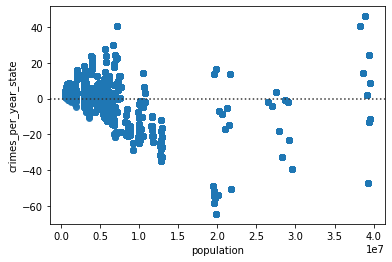

In [58]:
residfig = sns.residplot(x='population', y='crimes_per_year_state', data = crimes_us)

image1 = Image.open('residplot1.png')

st.image(image1)